**1. Load and Inspect Data**




In [1]:
import pandas as pd
import numpy as np

train_data = pd.read_csv('/kaggle/input/ueba-dbscan-iforest/train_data.csv', encoding='latin1')

print("Train Data Shape:", train_data.shape)

print(train_data.head())


Train Data Shape: (528690, 10)
   id            account         group              IP  \
0   1  xiaojiawei@qq.com  ÈËÊÂÐÐÕþÖÐÐÄ    192.168.1.50   
1   2  xiaojiawei@qq.com  ÈËÊÂÐÐÕþÖÐÐÄ   192.168.31.46   
2   3  xiaojiawei@qq.com  ÈËÊÂÐÐÕþÖÐÐÄ     192.168.2.3   
3   4  xiaojiawei@qq.com  ÈËÊÂÐÐÕþÖÐÐÄ  192.168.145.30   
4   5  xiaojiawei@qq.com  ÈËÊÂÐÐÕþÖÐÐÄ  192.168.178.92   

                               url   port  vlan      switchIP            time  \
0                http://123.6.4.41  15788   700  129.30.06.37  2021/6/16 7:56   
1           http://104.192.108.154  12665   700  152.91.89.45  2021/6/28 7:58   
2              http://42.236.37.80  25551   700  129.30.06.37   2021/6/1 6:37   
3  http://uf-api6-client.ksord.com  18274   700    162.6.8.29   2021/5/5 8:18   
4           http://101.199.128.170  34572   700    162.0.1.84  2021/6/20 6:52   

      ret  
0  0.1149  
1  0.1801  
2  0.3690  
3  0.1532  
4  0.1449  


In [2]:
print("Total observations:", len(train_data))
print("Unique accounts:", train_data['account'].nunique())
print("Unique IPs:", train_data['IP'].nunique())
print("Unique URLs:", train_data['url'].nunique())
print("Unique switchIPs:", train_data['switchIP'].nunique())

Total observations: 528690
Unique accounts: 151
Unique IPs: 133
Unique URLs: 1319
Unique switchIPs: 133


In [3]:
# Convert 'time' column to datetime and sort by time
train_data['time'] = pd.to_datetime(train_data['time'],format='%Y/%m/%d %H:%M')
train_data = train_data.sort_values(by='time')


In [4]:
# Temporal range of the dataset
start_time = train_data['time'].min()
end_time = train_data['time'].max()


In [5]:
print(f"First observation: {start_time}\nLatest observation: {end_time}")
print("Total observations:", len(train_data))
print("Unique accounts:", train_data['account'].nunique())
print("Unique IPs:", train_data['IP'].nunique())
print("Unique URLs:", train_data['url'].nunique())
print("Unique switchIPs:", train_data['switchIP'].nunique())

First observation: 2021-04-30 18:05:00
Latest observation: 2021-06-29 15:58:00
Total observations: 528690
Unique accounts: 151
Unique IPs: 133
Unique URLs: 1319
Unique switchIPs: 133


**2. Filter Data to Select Specific Users**

In [6]:
# Select a subset of users
unique_users = train_data['account'].unique()
selected_users = np.random.choice(unique_users, 5, replace=False)
filtered_df = train_data[train_data['account'].isin(selected_users)]


In [7]:
print("Total observations:", len(filtered_df))
print("Unique accounts:", filtered_df['account'].nunique())
print("Unique IPs:", filtered_df['IP'].nunique())
print("Unique URLs:", filtered_df['url'].nunique())
print("Unique switchIPs:", filtered_df['switchIP'].nunique())


Total observations: 12365
Unique accounts: 5
Unique IPs: 110
Unique URLs: 835
Unique switchIPs: 107


**2.1 Filter Data to Select Specific Time Ranges**

In [8]:
# Define the time range
start_date = '2021-06-26'
end_date = '2021-06-29'

# Filter data within the time range
sample_df = filtered_df[filtered_df['time'].between(start_date, end_date)]
sample_df.set_index('time', inplace=True, drop=False)

In [9]:
print("Total observations:", len(sample_df))
print("Unique accounts:", sample_df['account'].nunique())
print("Unique IPs:", sample_df['IP'].nunique())
print("Unique URLs:", sample_df['url'].nunique())
print("Unique switchIPs:", sample_df['switchIP'].nunique())


Total observations: 683
Unique accounts: 5
Unique IPs: 73
Unique URLs: 276
Unique switchIPs: 72


In [10]:
sample_df.columns

Index(['id', 'account', 'group', 'IP', 'url', 'port', 'vlan', 'switchIP',
       'time', 'ret'],
      dtype='object')

In [11]:
sample_df = sample_df.drop(columns=['id', 'group', 'port', 'vlan','ret', 'switchIP'])

In [12]:
sample_df.shape

(683, 4)

In [13]:
# numerical_features = [feature for feature in filtered_df.columns if sample_df[feature].dtypes != 'O' and sample_df[feature].dtype in ['int64', 'float64']]
# discrete_features=[feature for feature in numerical_features if len(filtered_df[feature].unique())<15]
# continuous_feature=[feature for feature in numerical_features if feature not in discrete_features]


**Label Encoding for categorical variables**

In [14]:
categorical_features=[feature for feature in sample_df.columns if sample_df[feature].dtypes=='O']


In [15]:
categorical_features

['account', 'IP', 'url']

In [16]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Apply LabelEncoder to each categorical column
for feature in categorical_features:
    sample_df[feature + '_encoded'] = le.fit_transform(sample_df[feature])
    

In [17]:
sample_df.head(3)

,account,IP,url,time,account_encoded,IP_encoded,url_encoded
time,,,,,,,
2021-06-26 02:37:00,jiangwei@qq.com,10.59.20.199,http://only-853333-154-16-166-210.nstool.netea...,2021-06-26 02:37:00,2,5,177
2021-06-26 02:38:00,jiangwei@qq.com,10.59.20.199,http://only-465448-210-12-140-210.nstool.yqkk....,2021-06-26 02:38:00,2,5,175
2021-06-26 02:38:00,jiangwei@qq.com,10.59.20.199,http://p8.qhmsg.com,2021-06-26 02:38:00,2,5,189


In [18]:
# Drop the original categorical columns 
sample_df = sample_df.drop(columns=categorical_features)
sample_df.head(5)

,time,account_encoded,IP_encoded,url_encoded
time,,,,
2021-06-26 02:37:00,2021-06-26 02:37:00,2,5,177
2021-06-26 02:38:00,2021-06-26 02:38:00,2,5,175
2021-06-26 02:38:00,2021-06-26 02:38:00,2,5,189
2021-06-26 02:38:00,2021-06-26 02:38:00,2,5,177
2021-06-26 02:38:00,2021-06-26 02:38:00,2,5,177


In [19]:
# **Feature Hashing for categorical variables**

# from sklearn.feature_extraction import FeatureHasher

# cols = sample_df[["account", "IP", "url"]]

# # Convert each value in the selected columns to a string
# cols = cols.map(str)

# # Convert selected columns to list of dictionaries
# data_dict = cols.to_dict(orient='records')

# # Initialize feature hasher
# hasher = FeatureHasher(n_features=10, input_type='string')
# hashed_features = hasher.fit_transform(data_dict).toarray()

# # Convert hashed features to DataFrame
# hashed_df = pd.DataFrame(hashed_features, columns=[f'feature_{i}' for i in range(hashed_features.shape[1])])

# # Combine the original DataFrame with hashed features
# result_df = pd.concat([cols.reset_index(), hashed_df], axis=1)

### **Pre-processing of Time column**

In [20]:
# Extract numerical features

sample_df['hour'] = sample_df['time'].dt.hour
sample_df['day_of_week'] = sample_df['time'].dt.day_of_week
sample_df['month'] = sample_df['time'].dt.month


In [21]:
sample_df.drop('time', axis=1, inplace=True)

In [22]:
sample_df.head(4)

,account_encoded,IP_encoded,url_encoded,hour,day_of_week,month
time,,,,,,
2021-06-26 02:37:00,2,5,177,2,5,6
2021-06-26 02:38:00,2,5,175,2,5,6
2021-06-26 02:38:00,2,5,189,2,5,6
2021-06-26 02:38:00,2,5,177,2,5,6


**4. Preprocess (Normalize) the Data**

In [23]:
from sklearn.preprocessing import StandardScaler

# Normalize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(sample_df)


**DBSCAN algorithm**

In [24]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN
epsilon = 0.5
min_samples = 5
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(scaled_data)

In [25]:
clusters

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0,
        0,  0,  1,  1,  0,  0,  2,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,
        0,  0,  1,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  0,
        1,  0,  0,  1,  1,  2,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  0,  0,  0,  0,  1,  0,  1,  0, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  5, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  3, -1,  3, -1, -1,  4, -1, -1,  3,
        3, -1, -1,  3,  4,  3, -1,  3,  3,  3, -1, -1, -1,  3, -1,  3,  4,
        3, -1,  3, -1, -1, -1,  3,  3, -1, -1,  4, -1, -1, -1, -1,  3,  3,
       -1, -1,  4, -1, -1,  3, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  0,
        0,  0,  0,  1,  0

In [26]:
index = np.where(clusters<0)
index

(array([ 97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
        110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
        123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
        136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
        149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 164,
        165, 167, 168, 171, 172, 176, 180, 181, 182, 184, 188, 190, 191,
        192, 195, 196, 198, 199, 200, 201, 204, 205, 207, 208, 210, 211,
        212, 213, 214, 215, 216, 217, 218, 295, 296, 297, 298, 299, 300,
        301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313,
        314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326,
        327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339,
        341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 352, 353, 354,
        355, 356, 357, 358, 359, 360, 362, 365, 366, 367, 368, 369, 370,
        371, 372, 373, 374, 375, 376, 379, 382, 384

#### Identify the core and the outliers


In [27]:
# Identify the core and the outliers
import numpy as np

core_samples = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples[dbscan.core_sample_indices_] = True
labels = dbscan.labels_

In [28]:
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0,
        0,  0,  1,  1,  0,  0,  2,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,
        0,  0,  1,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  0,
        1,  0,  0,  1,  1,  2,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  0,  0,  0,  0,  1,  0,  1,  0, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  5, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  3, -1,  3, -1, -1,  4, -1, -1,  3,
        3, -1, -1,  3,  4,  3, -1,  3,  3,  3, -1, -1, -1,  3, -1,  3,  4,
        3, -1,  3, -1, -1, -1,  3,  3, -1, -1,  4, -1, -1, -1, -1,  3,  3,
       -1, -1,  4, -1, -1,  3, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  0,
        0,  0,  0,  1,  0

In [29]:
# Check the number of clusters after DBSCAN algorithm (ignoring noise if present)

n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')


Estimated number of clusters: 14
Estimated number of noise points: 307


In [30]:
from sklearn.ensemble import IsolationForest

# Apply Isolation Forest
iso_forest = IsolationForest(contamination='auto', random_state=42)
iso_labels = iso_forest.fit_predict(scaled_data)


In [31]:
# Check the number of outliers after applying IForest algorithm (ignoring noise if present)

n_clusters_ = len(set(iso_labels)) - (1 if -1 in iso_labels else 0)
n_noise_ = list(iso_labels).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')


Estimated number of clusters: 1
Estimated number of noise points: 376


**7. Evaluate and Visualize Results**

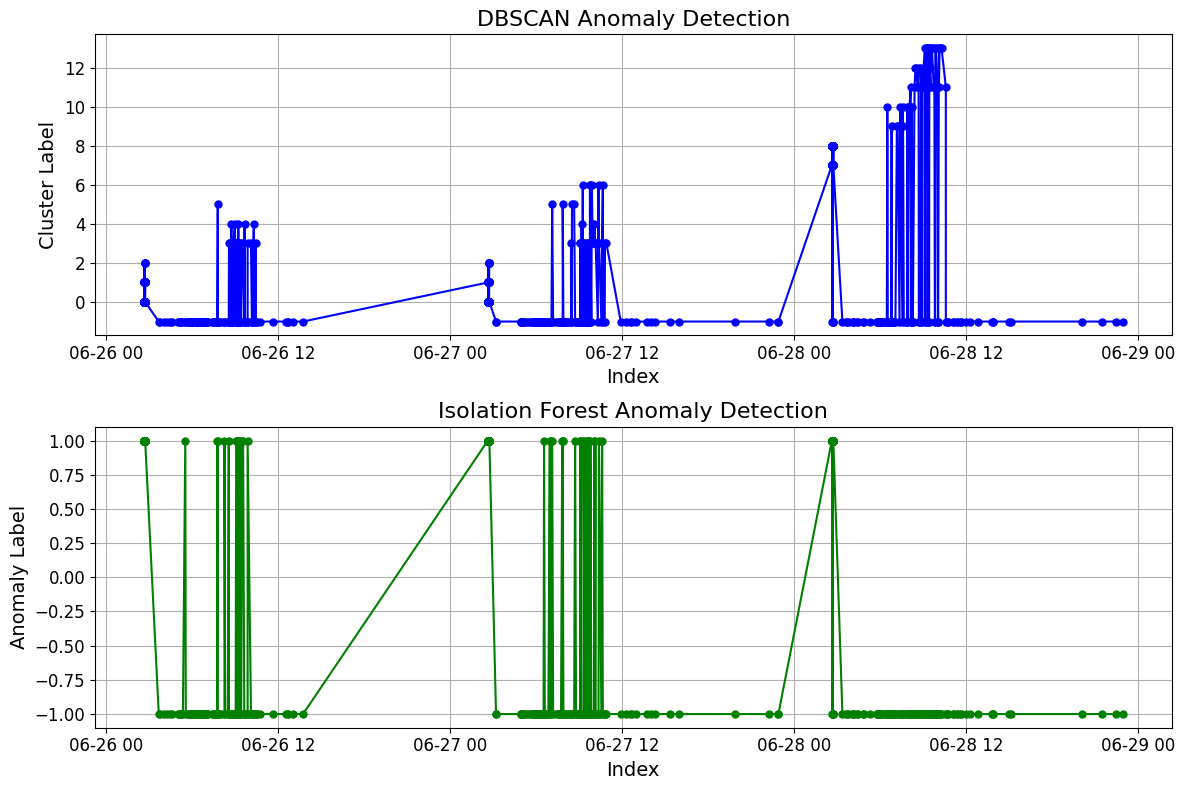

In [32]:
import matplotlib.pyplot as plt

# Create a figure with a specified size
plt.figure(figsize=(12, 8))

# Plot DBSCAN labels
plt.subplot(2, 1, 1)
plt.plot(sample_df.index, clusters, marker='o', linestyle='-', color='b', markersize=5)
plt.title('DBSCAN Anomaly Detection', fontsize=16)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Cluster Label', fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Plot Isolation Forest labels
plt.subplot(2, 1, 2)
plt.plot(sample_df.index, iso_labels, marker='o', linestyle='-', color='g', markersize=5)
plt.title('Isolation Forest Anomaly Detection', fontsize=16)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Anomaly Label', fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()


In [33]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Coefficient
silhouette_avg = silhouette_score(scaled_data, clusters)
print(f"Silhouette Coefficient: {silhouette_avg}")

Silhouette Coefficient: 0.19042737220597714


In [34]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Coefficient
silhouette_isolation_f = silhouette_score(scaled_data, iso_labels)
print(f"Silhouette Coefficient: {silhouette_isolation_f}")

Silhouette Coefficient: 0.19733065779086387


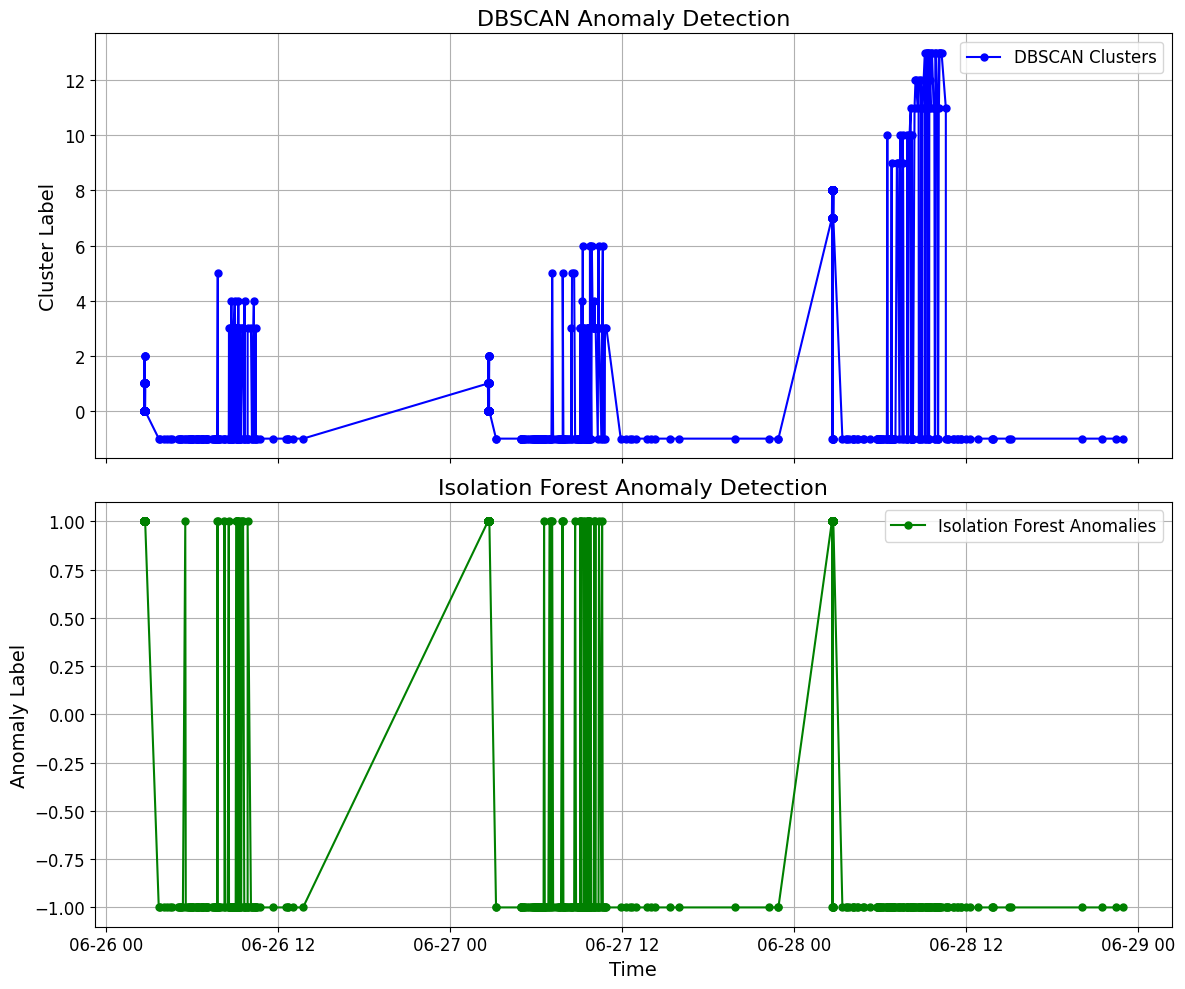

In [35]:
import matplotlib.pyplot as plt

# Create a figure with subplots and a specified size
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot DBSCAN labels
ax1.plot(sample_df.index, clusters, marker='o', linestyle='-', color='b', markersize=5, label='DBSCAN Clusters')
ax1.set_title('DBSCAN Anomaly Detection', fontsize=16)
ax1.set_ylabel('Cluster Label', fontsize=14)
ax1.grid(True)
ax1.legend(fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=12)

# Plot Isolation Forest labels
ax2.plot(sample_df.index, iso_labels, marker='o', linestyle='-', color='g', markersize=5, label='Isolation Forest Anomalies')
ax2.set_title('Isolation Forest Anomaly Detection', fontsize=16)
ax2.set_xlabel('Time', fontsize=14)
ax2.set_ylabel('Anomaly Label', fontsize=14)
ax2.grid(True)
ax2.legend(fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()
